# 🚀 Part 8: Inference & Deployment

**You've fine-tuned a model. Now what?**

This notebook covers how to actually **use** your fine-tuned model.

---

## What We'll Cover

| Topic | Description |
|-------|-------------|
| Quick Training | Train a model with Unsloth (fast!) |
| Local Inference | Run the model directly |
| Saving Formats | LoRA, merged, GGUF |
| HuggingFace Hub | Upload and share |
| GGUF + llama.cpp | Run on CPU/edge devices |
| Ollama Integration | Easy local deployment |

---

## Deployment Options Overview

```
┌─────────────────────────────────────────────────────────────────┐
│                    YOUR FINE-TUNED MODEL                        │
└─────────────────────────┬───────────────────────────────────────┘
                          │
          ┌───────────────┼───────────────┐
          │               │               │
          ▼               ▼               ▼
   ┌─────────────┐ ┌─────────────┐ ┌─────────────┐
   │   LoRA      │ │   Merged    │ │    GGUF     │
   │  Adapter    │ │   Model     │ │  (llama.cpp)│
   └──────┬──────┘ └──────┬──────┘ └──────┬──────┘
          │               │               │
          ▼               ▼               ▼
   ┌─────────────┐ ┌─────────────┐ ┌─────────────┐
   │ HuggingFace │ │   vLLM /    │ │   Ollama    │
   │ Inference   │ │   TGI       │ │   Local     │
   └─────────────┘ └─────────────┘ └─────────────┘
```

---

# Part A: Setup & Quick Training

Let's train a model quickly with Unsloth so we have something to deploy.

In [ ]:
!pip install -q unsloth
!pip install -q --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

You may need to restart session.

In [ ]:
import os

os.environ["UNSLOTH_DISABLE_PATCHING"] = "1"   # TRL patching closed
os.environ["UNSLOTH_USE_FUSED_LOSS"] = "0"     # fused loss closed
os.environ["UNSLOTH_DISABLE_COMPILE"] = "1"    # unsloth compile closed
os.environ["TORCHDYNAMO_DISABLE"] = "1"        # torch dynamo closed

In [ ]:
import torch
from unsloth import FastLanguageModel
from transformers import TrainingArguments
from trl import SFTTrainer

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [ ]:
# Check GPU
if torch.cuda.is_available():
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    print("❌ No GPU!")

✅ GPU: Tesla T4
   Memory: 15.8 GB


In [ ]:
# Configuration
MODEL_ID = "Qwen/Qwen2.5-0.5B-Instruct"
MAX_SEQ_LENGTH = 512

print(f"📋 Model: {MODEL_ID}")

📋 Model: Qwen/Qwen2.5-0.5B-Instruct


In [ ]:
# Load model with Unsloth
print("📦 Loading model...")
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=MODEL_ID,
    max_seq_length=MAX_SEQ_LENGTH,
    dtype=None,
    load_in_4bit=True,
)
print("✅ Model loaded!")

📦 Loading model...
==((====))==  Unsloth 2026.1.3: Fast Qwen2 patching. Transformers: 4.57.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
✅ Model loaded!


In [ ]:
# Apply LoRA
model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj",
                    "gate_proj", "up_proj", "down_proj"],
    use_gradient_checkpointing="unsloth",
    random_state=42,
)
print("✅ LoRA applied!")

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.05.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2026.1.3 patched 24 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


✅ LoRA applied!


In [1]:
# Load dataset
from datasets import load_dataset

dataset = load_dataset("mlabonne/guanaco-llama2-1k", split="train")
print(f"✅ Dataset: {len(dataset)} examples")

README.md: 0.00B [00:00, ?B/s]

D:\PyCharmProjects_Backup\SLM-FineTune\.venv\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\pelin\.cache\huggingface\hub\datasets--mlabonne--guanaco-llama2-1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


data/train-00000-of-00001-9ad84bb9cf65a4(…):   0%|          | 0.00/967k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

✅ Dataset: 1000 examples


In [2]:
# Explore the dataset
print("="*60)
print("📊 DATASET EXPLORATION")
print("="*60)

# Basic info
print(f"\n📋 Dataset size: {len(dataset)} examples")
print(f"📋 Features: {list(dataset.features.keys())}")

# Look at structure
print(f"\n🔍 First example:")
print("-"*60)
print(dataset[0]["text"][:500] + "..." if len(dataset[0]["text"]) > 500 else dataset[0]["text"])

# Text length statistics
text_lengths = [len(item["text"]) for item in dataset]
token_estimates = [len(item["text"].split()) for item in dataset]

print(f"\n📈 Text Length Statistics:")
print(f"   Min chars:     {min(text_lengths):,}")
print(f"   Max chars:     {max(text_lengths):,}")
print(f"   Avg chars:     {sum(text_lengths)//len(text_lengths):,}")
print(f"   Avg words:     {sum(token_estimates)//len(token_estimates):,}")

# Check format (Llama2 style)
sample = dataset[0]["text"]
has_inst = "[INST]" in sample
has_human = "### Human:" in sample
print(f"\n📝 Format detected:")
print(f"   Llama2 style [INST]: {has_inst}")
print(f"   Guanaco style ###:   {has_human}")

# Show a few more examples
print(f"\n🔍 Sample prompts (first 100 chars):")
for i in range(min(3, len(dataset))):
    preview = dataset[i]["text"][:100].replace("\n", " ")
    print(f"   [{i}] {preview}...")

📊 DATASET EXPLORATION

📋 Dataset size: 1000 examples
📋 Features: ['text']

🔍 First example:
------------------------------------------------------------
<s>[INST] Me gradué hace poco de la carrera de medicina ¿Me podrías aconsejar para conseguir rápidamente un puesto de trabajo? [/INST] Esto vale tanto para médicos como para cualquier otra profesión tras finalizar los estudios aniversarios y mi consejo sería preguntar a cuántas personas haya conocido mejor. En este caso, mi primera opción sería hablar con otros profesionales médicos, echar currículos en hospitales y cualquier centro de salud. En paralelo, trabajaría por mejorar mi marca personal...

📈 Text Length Statistics:
   Min chars:     58
   Max chars:     11,443
   Avg chars:     1,499
   Avg words:     234

📝 Format detected:
   Llama2 style [INST]: True
   Guanaco style ###:   False

🔍 Sample prompts (first 100 chars):
   [0] <s>[INST] Me gradué hace poco de la carrera de medicina ¿Me podrías aconsejar para conseguir rápidam.

📊 Approximate Token Length Statistics:
   Min: 6
   Max: 2245
   Mean: 304
   Examples > 512 tokens: 155 (15.5%)
   Examples > 1024 tokens: 16 (1.6%)


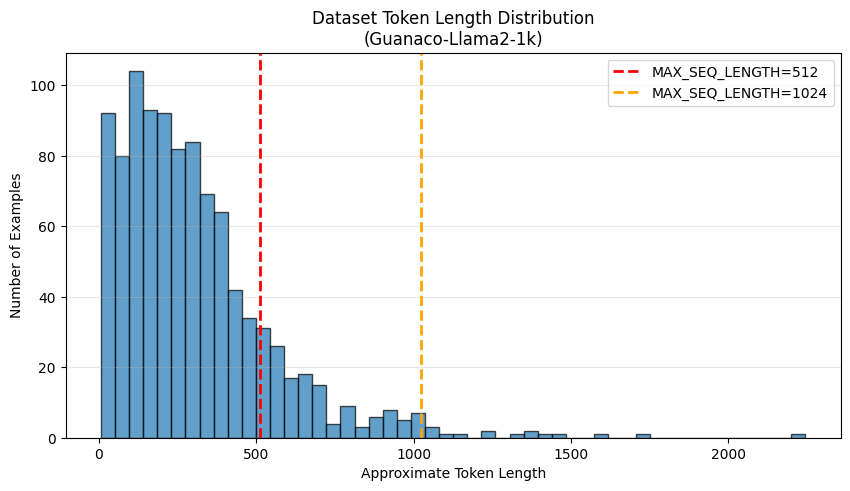


📈 Data Retention:
   With max_length=512:  845/1000 examples fully kept (84.5%)
   With max_length=1024: 984/1000 examples fully kept (98.4%)


In [4]:
# Analyze dataset text lengths (no tokenizer needed)
from datasets import load_dataset
import matplotlib.pyplot as plt

# Load dataset (quick, just metadata)
dataset = load_dataset("mlabonne/guanaco-llama2-1k", split="train")

# Approximate tokens by words (rough estimate: 1 word ≈ 1.3 tokens)
word_lengths = [len(ex["text"].split()) for ex in dataset]
approx_tokens = [int(w * 1.3) for w in word_lengths]

print(f"📊 Approximate Token Length Statistics:")
print(f"   Min: {min(approx_tokens)}")
print(f"   Max: {max(approx_tokens)}")
print(f"   Mean: {sum(approx_tokens)//len(approx_tokens)}")
print(f"   Examples > 512 tokens: {sum(1 for l in approx_tokens if l > 512)} ({100*sum(1 for l in approx_tokens if l > 512)/len(approx_tokens):.1f}%)")
print(f"   Examples > 1024 tokens: {sum(1 for l in approx_tokens if l > 1024)} ({100*sum(1 for l in approx_tokens if l > 1024)/len(approx_tokens):.1f}%)")

plt.figure(figsize=(10, 5))
plt.hist(approx_tokens, bins=50, edgecolor='black', alpha=0.7)
plt.axvline(x=512, color='r', linestyle='--', linewidth=2, label='MAX_SEQ_LENGTH=512')
plt.axvline(x=1024, color='orange', linestyle='--', linewidth=2, label='MAX_SEQ_LENGTH=1024')
plt.xlabel("Approximate Token Length")
plt.ylabel("Number of Examples")
plt.title("Dataset Token Length Distribution\n(Guanaco-Llama2-1k)")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

# Show what percentage of data is kept/lost
kept_512 = sum(1 for l in approx_tokens if l <= 512)
kept_1024 = sum(1 for l in approx_tokens if l <= 1024)
print(f"\n📈 Data Retention:")
print(f"   With max_length=512:  {kept_512}/{len(dataset)} examples fully kept ({100*kept_512/len(dataset):.1f}%)")
print(f"   With max_length=1024: {kept_1024}/{len(dataset)} examples fully kept ({100*kept_1024/len(dataset):.1f}%)")

## This code gives error. I will fix it.

In [ ]:
# Training arguments - quick training
training_args = TrainingArguments(
    output_dir="./output",
    num_train_epochs=1,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    learning_rate=2e-4,
    fp16=not torch.cuda.is_bf16_supported(),
    bf16=torch.cuda.is_bf16_supported(),
    logging_steps=50,
    save_strategy="no",
    optim="adamw_8bit",
    warmup_ratio=0.03,
    report_to="none",
)

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=dataset,
    tokenizer=tokenizer,
    # max_seq_length=MAX_SEQ_LENGTH,
    dataset_text_field="text",
    packing=False,
)

print("✅ Trainer ready!")

✅ Trainer ready!


In [ ]:
# Train!
import time
print("🚀 Training...\n")
start = time.time()

trainer.train()

train_time = time.time() - start
print(f"\n✅ Training complete in {train_time:.0f} seconds!")

The model is already on multiple devices. Skipping the move to device specified in `args`.


🚀 Training...



==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,000 | Num Epochs = 1 | Total steps = 125
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 2 x 1) = 8
 "-____-"     Trainable parameters = 8,798,208 of 502,830,976 (1.75% trained)
Unsloth: Input IDs of shape torch.Size([4, 526]) with length 526 > the model's max sequence length of 512.
We shall truncate it ourselves. It's imperative if you correct this issue first.


ValueError: Expected input batch_size (2048) to match target batch_size (2104).

## FIX

In [ ]:
def tok_fn(examples):
    out = tokenizer(
        examples["text"],
        truncation=True,   # ✅ Cut sequences > MAX_SEQ_LENGTH
        max_length=MAX_SEQ_LENGTH,
        padding=False,          # important: no padding in dataset
    )
    return out

tokenized_dataset = dataset.map(tok_fn, batched=True, remove_columns=dataset.column_names)


**What this does:**
- Tokenizes all text BEFORE training
- Truncates anything over 512 tokens
- `padding=False` — no padding yet (each example is different length)
- `remove_columns` — removes original "text" column, keeps only token IDs
```
Before: {"text": "very long string..."}
After:  {"input_ids": [1, 234, 567, ...], "attention_mask": [1, 1, 1, ...]}
         (max 512 tokens)

In [ ]:
from transformers import DataCollatorForSeq2Seq

# Training arguments - quick training
training_args = TrainingArguments(
    output_dir="./output",
    num_train_epochs=1,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=2,
    learning_rate=2e-4,
    fp16=True,
    bf16=False,
    logging_steps=50,
    save_strategy="no",
    optim="adamw_8bit",
    warmup_ratio=0.03,
    report_to="none",
)

# Data collator with proper truncation
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    padding=True,
    pad_to_multiple_of=8,
)

trainer = SFTTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset,
    tokenizer=tokenizer,
    max_seq_length=MAX_SEQ_LENGTH,
    dataset_text_field="text",
    packing=False,
    data_collator=data_collator,
    dataset_kwargs={
        "add_special_tokens": False,
        "append_concat_token": False,
    },
)

print("✅ Trainer ready!")

✅ Trainer ready!


    data_collator = DataCollatorForSeq2Seq(
        tokenizer=tokenizer,
        padding=True,              # ✅ Pad to longest in batch
        pad_to_multiple_of=8,      # ✅ Pad to multiple of 8 (GPU efficiency)
    )
    ```

**What this does:**
- When creating a batch, pads all examples to the same length
- Only pads to the longest sequence IN THAT BATCH (not globally)
- `pad_to_multiple_of=8` — GPU tensor operations are faster with dimensions divisible by 8
```
Batch example:
  Example 1: [1, 2, 3, 4, 5]         → [1, 2, 3, 4, 5, PAD, PAD, PAD]
  Example 2: [1, 2, 3]               → [1, 2, 3, PAD, PAD, PAD, PAD, PAD]  
  Example 3: [1, 2, 3, 4, 5, 6, 7]   → [1, 2, 3, 4, 5, 6, 7, PAD]
                                        ↑ padded to 8 (multiple of 8)

In [ ]:
# Train!
import time
print("🚀 Training...\n")
start = time.time()

trainer.train()

train_time = time.time() - start
print(f"\n✅ Training complete in {train_time:.0f} seconds!")

The model is already on multiple devices. Skipping the move to device specified in `args`.


🚀 Training...



==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,000 | Num Epochs = 1 | Total steps = 125
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 2
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 2 x 1) = 8
 "-____-"     Trainable parameters = 8,798,208 of 502,830,976 (1.75% trained)


Step,Training Loss
50,1.860000
100,1.806100



✅ Training complete in 115 seconds!


---

# Part B: Local Inference

The simplest way to use your model: run it directly!

In [ ]:
# Enable fast inference mode
FastLanguageModel.for_inference(model)
print("✅ Inference mode enabled")

✅ Inference mode enabled


In [ ]:
def chat(prompt, max_tokens=256):
    """Simple chat function."""
    messages = [{"role": "user", "content": prompt}]

    inputs = tokenizer.apply_chat_template(
        messages,
        tokenize=True,
        add_generation_prompt=True,
        return_tensors="pt"
    ).to("cuda")

    outputs = model.generate(
        input_ids=inputs,
        max_new_tokens=max_tokens,
        temperature=0.7,
        do_sample=True,
        top_p=0.9,
        pad_token_id=tokenizer.pad_token_id,
    )

    response = tokenizer.decode(outputs[0][inputs.shape[1]:], skip_special_tokens=True)
    return response

print("✅ chat() function ready")

✅ chat() function ready


In [ ]:
# Test the model
print("🧪 Testing the fine-tuned model:\n")

test_prompts = [
    "What is machine learning?",
    "Write a Python function to reverse a string.",
    "Give me 3 tips for better sleep.",
]

for prompt in test_prompts:
    print(f"👤 User: {prompt}")
    response = chat(prompt)
    print(f"🤖 Assistant: {response}")
    print("-" * 50)

🧪 Testing the fine-tuned model:

👤 User: What is machine learning?
🤖 Assistant: Machine learning (ML) is a subset of artificial intelligence that involves the development of algorithms and models that enable computers to learn from data and make decisions or predictions based on this learning. It has been used in a wide range of applications, including image recognition, speech recognition, natural language processing, predictive analytics, and more.

The process of machine learning typically starts with collecting and preprocessing data, which may include cleaning, transforming, and normalizing it. Then, there is an iterative phase where new data is fed into the model to improve its accuracy over time. The final stage involves testing and validating the model's performance using various metrics such as accuracy, precision, recall, F1 score, and others.

In summary, machine learning is a powerful technique for enabling machines to automatically learn patterns from data and perform task

---

# Part C: Saving Your Model

Multiple formats for different use cases:

| Format | Size | Use Case |
|--------|------|----------|
| LoRA adapter | ~10-50 MB | Share adapters, combine with base |
| Merged 16-bit | ~1-14 GB | HuggingFace, full precision |
| Merged 4-bit | ~0.5-4 GB | Smaller, quantized |
| GGUF | ~0.3-8 GB | llama.cpp, Ollama, CPU inference |

## Option 1: Save LoRA Adapter Only

Smallest size. Requires base model to use.

In [ ]:
# Save LoRA adapter
LORA_PATH = "./my_lora_adapter"

model.save_pretrained(LORA_PATH)
tokenizer.save_pretrained(LORA_PATH)

# Check size
import os
lora_size = sum(os.path.getsize(os.path.join(LORA_PATH, f))
               for f in os.listdir(LORA_PATH)
               if os.path.isfile(os.path.join(LORA_PATH, f)))

print(f"✅ LoRA adapter saved to {LORA_PATH}")
print(f"   Size: {lora_size / 1e6:.1f} MB")
print(f"\n📁 Contents:")
for f in os.listdir(LORA_PATH):
    size = os.path.getsize(os.path.join(LORA_PATH, f)) / 1e6
    print(f"   {f}: {size:.1f} MB")

✅ LoRA adapter saved to ./my_lora_adapter
   Size: 51.1 MB

📁 Contents:
   special_tokens_map.json: 0.0 MB
   vocab.json: 2.8 MB
   chat_template.jinja: 0.0 MB
   tokenizer.json: 11.4 MB
   README.md: 0.0 MB
   added_tokens.json: 0.0 MB
   adapter_config.json: 0.0 MB
   tokenizer_config.json: 0.0 MB
   adapter_model.safetensors: 35.2 MB
   merges.txt: 1.7 MB


## Option 2: Save Merged Model (16-bit)

Full model with adapter weights merged in. Ready for HuggingFace.

In [ ]:
# Save merged 16-bit model
MERGED_PATH = "./my_merged_model"

model.save_pretrained_merged(
    MERGED_PATH,
    tokenizer,
    save_method="merged_16bit",
)

print(f"✅ Merged model saved to {MERGED_PATH}")

# Check size
merged_size = sum(os.path.getsize(os.path.join(MERGED_PATH, f))
                 for f in os.listdir(MERGED_PATH)
                 if os.path.isfile(os.path.join(MERGED_PATH, f)))
print(f"   Size: {merged_size / 1e9:.2f} GB")

Found HuggingFace hub cache directory: /root/.cache/huggingface/hub
Checking cache directory for required files...
Cache check failed: model.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.
Checking cache directory for required files...
Cache check failed: tokenizer.model not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Unsloth: Preparing safetensor model files:   0%|          | 0/1 [00:00<?, ?it/s]

Unsloth: Preparing safetensor model files: 100%|██████████| 1/1 [00:07<00:00,  7.46s/it]


Note: tokenizer.model not found (this is OK for non-SentencePiece models)


Unsloth: Merging weights into 16bit: 100%|██████████| 1/1 [00:14<00:00, 14.55s/it]


Unsloth: Merge process complete. Saved to `/content/my_merged_model`
✅ Merged model saved to ./my_merged_model
   Size: 1.00 GB


## Option 3: Save as GGUF (for llama.cpp / Ollama)

GGUF is the format used by:
- **llama.cpp** — C++ inference engine
- **Ollama** — Easy local LLM runner
- **LM Studio** — Desktop app for LLMs
- **GPT4All** — Local LLM platform

### Quantization Options

| Method | Bits | Size | Quality | Speed |
|--------|------|------|---------|-------|
| q8_0 | 8-bit | Large | Best | Slow |
| q5_k_m | 5-bit | Medium | Great | Medium |
| q4_k_m | 4-bit | Small | Good | Fast |
| q3_k_m | 3-bit | Tiny | OK | Fastest |
| q2_k | 2-bit | Smallest | Poor | Fastest |

In [ ]:
# Save as GGUF with different quantizations
GGUF_PATH = "./my_model_gguf"

# q4_k_m is a good balance of size and quality
model.save_pretrained_gguf(
    GGUF_PATH,
    tokenizer,
    quantization_method="q8_0",
)

print(f"\n✅ GGUF model saved!")

# List GGUF files
print(f"\n📁 GGUF files:")
for f in os.listdir(GGUF_PATH):
    if f.endswith('.gguf'):
        size = os.path.getsize(os.path.join(GGUF_PATH, f)) / 1e9
        print(f"   {f}: {size:.2f} GB")

Unsloth: Merging model weights to 16-bit format...
Found HuggingFace hub cache directory: /root/.cache/huggingface/hub
Checking cache directory for required files...
Cache check failed: model.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.
Checking cache directory for required files...
Cache check failed: tokenizer.model not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Unsloth: Preparing safetensor model files: 100%|██████████| 1/1 [00:00<00:00, 7345.54it/s]


Note: tokenizer.model not found (this is OK for non-SentencePiece models)


Unsloth: Merging weights into 16bit: 100%|██████████| 1/1 [00:22<00:00, 22.31s/it]


Unsloth: Merge process complete. Saved to `/content/my_model_gguf`
Unsloth: All required system packages already installed!
Unsloth: Initial conversion completed! Files: ['qwen2.5-0.5b-instruct.F16.gguf']
Unsloth: Model files cleanup...
Unsloth: All GGUF conversions completed successfully!
Unsloth: Saved Ollama Modelfile to current directory
Unsloth: convert model to ollama format by running - ollama create model_name -f ./Modelfile - inside current directory.
✅ GGUF model saved!


---

# Part D: Upload to HuggingFace Hub

Share your model with the world!

In [ ]:
# Login to HuggingFace (you'll need a token)
# Get your token at: https://huggingface.co/settings/tokens

from huggingface_hub import login

# Option 1: Login interactively
login()

# Option 2: Use token directly (uncomment and add your token)
# login(token="hf_your_token_here")

print("💡 To upload, run: login() or login(token='your_token')")

💡 To upload, run: login() or login(token='your_token')


In [ ]:
# Upload options (uncomment to use)

HUB_USERNAME = "pelinbalci"  # Change this!
MODEL_NAME = "my-qwen-finetuned"

print("📤 Upload commands (uncomment to use):")

# Upload LoRA adapter only
model.push_to_hub(
    f"{HUB_USERNAME}/{MODEL_NAME}-lora",
    tokenizer=tokenizer,
)

# Upload merged 16-bit model
model.push_to_hub_merged(
    f"{HUB_USERNAME}/{MODEL_NAME}",
    tokenizer,
    save_method="merged_16bit",
)

# Upload GGUF (for Ollama users)
model.push_to_hub_gguf(
    f"{HUB_USERNAME}/{MODEL_NAME}-gguf",
    tokenizer,
    quantization_method="q8_0",
)

📤 Upload commands (uncomment to use):


Saved model to https://huggingface.co/pelinbalci/my-qwen-finetuned-lora


Found HuggingFace hub cache directory: /root/.cache/huggingface/hub
Checking cache directory for required files...
Cache check failed: model.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.
Checking cache directory for required files...
Cache check failed: tokenizer.model not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Unsloth: Preparing safetensor model files:   0%|          | 0/1 [00:00<?, ?it/s]

Unsloth: Preparing safetensor model files: 100%|██████████| 1/1 [00:22<00:00, 22.14s/it]


Note: tokenizer.model not found (this is OK for non-SentencePiece models)


Unsloth: Merging weights into 16bit:   0%|          | 0/1 [00:00<?, ?it/s]

Unsloth: Merging weights into 16bit: 100%|██████████| 1/1 [00:48<00:00, 48.41s/it]


Unsloth: Merge process complete. Saved to `/content/pelinbalci/my-qwen-finetuned`
Unsloth: Converting model to GGUF format...
Unsloth: Merging model weights to 16-bit format...
Found HuggingFace hub cache directory: /root/.cache/huggingface/hub
Checking cache directory for required files...
Cache check failed: model.safetensors not found in local cache.
Not all required files found in cache. Will proceed with downloading.
Checking cache directory for required files...
Cache check failed: tokenizer.model not found in local cache.
Not all required files found in cache. Will proceed with downloading.


Unsloth: Preparing safetensor model files:   0%|          | 0/1 [00:00<?, ?it/s]

Unsloth: Preparing safetensor model files: 100%|██████████| 1/1 [00:16<00:00, 16.17s/it]


Note: tokenizer.model not found (this is OK for non-SentencePiece models)


Unsloth: Merging weights into 16bit: 100%|██████████| 1/1 [00:49<00:00, 49.96s/it]


Unsloth: Merge process complete. Saved to `/tmp/unsloth_gguf_ggroe1i7`
Unsloth: Initial conversion completed! Files: ['qwen2.5-0.5b-instruct.F16.gguf']
Unsloth: Model files cleanup...
Unsloth: All GGUF conversions completed successfully!
Unsloth: Saved Ollama Modelfile to current directory
Unsloth: convert model to ollama format by running - ollama create model_name -f ./Modelfile - inside current directory.


Uploading config.json...
Uploading Ollama Modelfile...
Unsloth: Successfully uploaded GGUF to https://huggingface.co/pelinbalci/my-qwen-finetuned-gguf
Unsloth: Cleaning up temporary files...


'pelinbalci/my-qwen-finetuned-gguf'

---

# Part E: Using Your Model

## Option 1: Load LoRA Adapter Later

In [ ]:
# How to load your LoRA adapter later
print("📝 Loading LoRA adapter:")

from unsloth import FastLanguageModel

# Load base model + your adapter
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="./my_lora_adapter",  # or "username/model-lora" from Hub
    max_seq_length=512,
    load_in_4bit=True,
)

# Enable inference
FastLanguageModel.for_inference(model)

# ✅ USE CHAT TEMPLATE
messages = [{"role": "user", "content": "Hello!"}]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_tensors="pt"
).to("cuda")

outputs = model.generate(
    input_ids=inputs,
    max_new_tokens=100,
    temperature=0.7,
    do_sample=True,
)

# ✅ DECODE ONLY NEW TOKENS
response = tokenizer.decode(outputs[0][inputs.shape[1]:], skip_special_tokens=True)
print("-------")
print(response)

📝 Loading LoRA adapter:
==((====))==  Unsloth 2026.1.3: Fast Qwen2 patching. Transformers: 4.57.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
-------
Hello! How can I assist you today? Please let me know if there is anything specific or urgent that needs attention.


In [ ]:
# How to load your LoRA adapter later
print("📝 Loading LoRA adapter:")

from unsloth import FastLanguageModel

# Load base model + your adapter
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="pelinbalci/my-qwen-finetuned-lora",  # or "username/model-lora" from Hub
    max_seq_length=512,
    load_in_4bit=True,
)

# Enable inference
FastLanguageModel.for_inference(model)

# ✅ USE CHAT TEMPLATE
messages = [{"role": "user", "content": "Hello!"}]
inputs = tokenizer.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_tensors="pt"
).to("cuda")

outputs = model.generate(
    input_ids=inputs,
    max_new_tokens=100,
    temperature=0.7,
    do_sample=True,
)

# ✅ DECODE ONLY NEW TOKENS
response = tokenizer.decode(outputs[0][inputs.shape[1]:], skip_special_tokens=True)
print("-------")
print(response)

📝 Loading LoRA adapter:
==((====))==  Unsloth 2026.1.3: Fast Qwen2 patching. Transformers: 4.57.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
-------
Hello! How can I assist you today? Please let me know if there is anything specific you would like to ask or discuss.


## Option 2: Use with Ollama

Ollama makes it super easy to run models locally.


🦙 Ollama Deployment Explained

First, an important note: That cell mixes bash commands with Python, which won't work directly in a notebook. It's meant as documentation/instructions for local deployment.


**Step-by-Step Breakdown**

1. Install Ollama

    bashcurl -fsSL https://ollama.ai/install.sh | sh

Downloads and installs Ollama on your local machine (Mac, Linux, or Windows WSL). This is a one-time setup.

2. Create a Modelfile

bash
    
    cat > Modelfile << 'EOF'
    ...
    EOF
    ```

This creates a configuration file that tells Ollama how to use your model:

| Component | Purpose |
|-----------|---------|
| `FROM ./path/to/model.gguf` | Points to your GGUF model file |
| `TEMPLATE` | Defines the chat format (must match your model's training format) |
| `PARAMETER stop` | Tokens that signal end of response |
| `PARAMETER temperature` | Controls randomness (0.7 = balanced) |

**3. The Template Explained**

For Qwen2.5, the chat format uses ChatML style:


    ```
    <|im_start|>system
    You are a helpful assistant.<|im_end|>
    <|im_start|>user
    Hello!<|im_end|>
    <|im_start|>assistant
    Hi there!<|im_end|>

The template in the Modelfile maps Ollama's variables to this format.

4. Create & Run

bash

    ollama create my-qwen -f Modelfile  # Registers the model
    ollama run my-qwen "What is Python?"  # Runs inference


In [ ]:
print("""
═══════════════════════════════════════════════════════════════
📝 NOTE: These are terminal commands for LOCAL deployment.
   Copy and run them on your own machine, not in Colab.
═══════════════════════════════════════════════════════════════
""")


print("""
🦙 OLLAMA DEPLOYMENT (run these commands in your terminal, not in notebook)

# 1. Install Ollama (one-time)
curl -fsSL https://ollama.ai/install.sh | sh

# 2. Download your GGUF from HuggingFace
# Either manually or:
huggingface-cli download pelinbalci/my-qwen-finetuned-gguf --local-dir ./my_model

# 3. Create Modelfile (save this as a file named 'Modelfile')
""")

modelfile_content = '''FROM ./qwen2.5-0.5b-instruct.Q8_0.gguf

TEMPLATE """{{ if .System }}<|im_start|>system
{{ .System }}<|im_end|>
{{ end }}{{ if .Prompt }}<|im_start|>user
{{ .Prompt }}<|im_end|>
{{ end }}<|im_start|>assistant
{{ .Response }}<|im_end|>
"""

PARAMETER stop "<|im_start|>"
PARAMETER stop "<|im_end|>"
PARAMETER temperature 0.7
'''

print(modelfile_content)

print("""
# 4. Create and run the model
ollama create my-qwen -f Modelfile
ollama run my-qwen "What is Python?"

# 5. Or use the API
curl http://localhost:11434/api/generate -d '{
  "model": "my-qwen",
  "prompt": "What is machine learning?"
}'
""")

## Option 3: Use with llama.cpp Directly

🔧 llama.cpp Explained

llama.cpp is a C/C++ inference engine for running GGUF models - it's actually what powers Ollama under the hood. It's lower-level but gives you more control.


When to Use What
| Tool | BEst For |
|-----------|---------|
|Ollama   |Easy local deployment, quick setup|
|llama.cpp  |Maximum control, custom integrations, embedded systems|
|vLLM/TGI |Production servers with high throughput|



The Commands Explained

1. Build llama.cpp

bash

    git clone https://github.com/ggerganov/llama.cpp
    cd llama.cpp
    make -j  # Compiles the C++ code

2. Direct inference (one-shot)


    ./llama-cli -m /path/to/model.gguf \
          -p "What is machine learning?" \
          -n 256 \      # max tokens to generate
          --temp 0.7    # temperature


3. Server mode (API endpoint)


    ./llama-server -m /path/to/model.gguf --port 8080


In [ ]:
print("""
═══════════════════════════════════════════════════════════════
📝 NOTE: These are terminal commands for LOCAL deployment.
   Copy and run them on your own machine, not in Colab.
═══════════════════════════════════════════════════════════════
""")

print("🔧 Using with llama.cpp:")
print("""
# 1. Clone and build llama.cpp
git clone https://github.com/ggerganov/llama.cpp
cd llama.cpp
make -j

# 2. Run inference (note: 'main' is now 'llama-cli')
./llama-cli -m ./qwen2.5-0.5b-instruct.Q8_0.gguf \\
       -p "What is machine learning?" \\
       -n 256 \\
       --temp 0.7

# 3. Or start a server (note: 'server' is now 'llama-server')
./llama-server -m ./qwen2.5-0.5b-instruct.Q8_0.gguf --port 8080

# Then call via API:
curl http://localhost:8080/completion \\
     -H "Content-Type: application/json" \\
     -d '{"prompt": "Hello!", "n_predict": 100}'
""")

## Option 4: Python API Server (Simple)

In [ ]:
print("🐍 Simple Python API Server:")

# server.py
from fastapi import FastAPI
from pydantic import BaseModel
from unsloth import FastLanguageModel

app = FastAPI()

# Load model once at startup
# Option 1: From local adapter
# model, tokenizer = FastLanguageModel.from_pretrained(
#     "./my_lora_adapter",
#     max_seq_length=512,
#     load_in_4bit=True,
# )

# Option 2: From HuggingFace Hub ✅
model, tokenizer = FastLanguageModel.from_pretrained(
    "pelinbalci/my-qwen-finetuned-lora",
    max_seq_length=512,
    load_in_4bit=True,
)
FastLanguageModel.for_inference(model)

class ChatRequest(BaseModel):
    message: str
    max_tokens: int = 256

@app.post("/chat")
async def chat(request: ChatRequest):
    messages = [{"role": "user", "content": request.message}]
    inputs = tokenizer.apply_chat_template(
        messages, tokenize=True,
        add_generation_prompt=True, return_tensors="pt"
    ).to("cuda")

    outputs = model.generate(
        input_ids=inputs,
        max_new_tokens=request.max_tokens,
        temperature=0.7,
        do_sample=True,
    )

    response = tokenizer.decode(outputs[0][inputs.shape[1]:], skip_special_tokens=True)
    return {"response": response}

# Run with: uvicorn server:app --host 0.0.0.0 --port 8000

# Test with:
# curl -X POST http://localhost:8000/chat \\
#      -H "Content-Type: application/json" \\
#      -d '{"message": "What is Python?"}'

🐍 Simple Python API Server:
==((====))==  Unsloth 2026.1.3: Fast Qwen2 patching. Transformers: 4.57.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


## Let's use it this notebook :)

In [ ]:
# Cell 1: Install dependencies
!pip install fastapi uvicorn nest-asyncio pyngrok -q

In [ ]:
# Cell 2: Create and run the server
import nest_asyncio
import uvicorn
from fastapi import FastAPI
from pydantic import BaseModel
from unsloth import FastLanguageModel
import threading

# Allow nested event loops (needed for Colab)
nest_asyncio.apply()

# Create FastAPI app
app = FastAPI()

# Load model (use already loaded model if available, or load fresh)
print("📦 Loading model...")
model, tokenizer = FastLanguageModel.from_pretrained(
    "pelinbalci/my-qwen-finetuned-lora",
    max_seq_length=512,
    load_in_4bit=True,
)
FastLanguageModel.for_inference(model)
print("✅ Model ready!")

class ChatRequest(BaseModel):
    message: str
    max_tokens: int = 256

@app.post("/chat")
async def chat(request: ChatRequest):
    messages = [{"role": "user", "content": request.message}]
    inputs = tokenizer.apply_chat_template(
        messages, tokenize=True,
        add_generation_prompt=True, return_tensors="pt"
    ).to("cuda")

    outputs = model.generate(
        input_ids=inputs,
        max_new_tokens=request.max_tokens,
        temperature=0.7,
        do_sample=True,
    )

    response = tokenizer.decode(outputs[0][inputs.shape[1]:], skip_special_tokens=True)
    return {"response": response}

@app.get("/health")
async def health():
    return {"status": "ok"}

# Start server in background thread
def run_server():
    uvicorn.run(app, host="0.0.0.0", port=8000)

thread = threading.Thread(target=run_server, daemon=True)
thread.start()
print("🚀 Server running on port 8000")

📦 Loading model...
==((====))==  Unsloth 2026.1.3: Fast Qwen2 patching. Transformers: 4.57.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.1+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.5.1
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
✅ Model ready!
🚀 Server running on port 8000


In [ ]:
# Cell 3: Test the endpoint
import requests

# Test health
print(requests.get("http://localhost:8000/health").json())

# Test chat
response = requests.post(
    "http://localhost:8000/chat",
    json={"message": "What is machine learning?", "max_tokens": 100}
)
print(response.json())

INFO:     127.0.0.1:50386 - "GET /health HTTP/1.1" 200 OK
{'status': 'ok'}
INFO:     127.0.0.1:50396 - "POST /chat HTTP/1.1" 200 OK
{'response': 'Machine learning is a subfield of artificial intelligence (AI) that involves the development and application of algorithms to enable computers to learn from data and make decisions based on new information. In other words, it is a method of creating intelligent machines that can learn from experience and adapt to new situations.\n\nThere are several types of machine learning, including supervised learning, unsupervised learning, and reinforcement learning. Supervised learning involves training a model using labeled data, while unsupervised learning involves finding patterns in unl'}


In [ ]:
# Cell 4: Interactive testing
test_prompts = [
    "What is Python?",
    "Write a haiku about coding",
    "Explain AI in one sentence",
]

for prompt in test_prompts:
    response = requests.post(
        "http://localhost:8000/chat",
        json={"message": prompt, "max_tokens": 100}
    )
    print(f"👤 {prompt}")
    print(f"🤖 {response.json()['response']}")
    print("-" * 50)

INFO:     127.0.0.1:50410 - "POST /chat HTTP/1.1" 200 OK
👤 What is Python?
🤖 Python is a high-level, general-purpose programming language that was developed in 1991 by Guido van Rossum and first released as an open-source software project in 1995. It has since become one of the most popular programming languages in the world, with over 20 million active users and over 370,000 open source projects.

Python is known for its simplicity and readability, making it easy to learn and use for beginners. It has a
--------------------------------------------------
INFO:     127.0.0.1:41824 - "POST /chat HTTP/1.1" 200 OK
👤 Write a haiku about coding
🤖 Code flows like water,
Syntax and logic blend together,
Life's adventures in the digital realm.
--------------------------------------------------
INFO:     127.0.0.1:41826 - "POST /chat HTTP/1.1" 200 OK
👤 Explain AI in one sentence
🤖 Artificial intelligence (AI) refers to the simulation of human intelligence in machines that improve over time throu

In [ ]:
print("""

# Cell 5: Create public URL (optional)
from pyngrok import ngrok

# Get auth token from https://ngrok.com (free account)
# ngrok.set_auth_token("your_token_here")

public_url = ngrok.connect(8000)
print(f"🌐 Public URL: {public_url}")
print(f"   Test with: curl -X POST {public_url}/chat -H 'Content-Type: application/json' -d '{{\"message\": \"Hello!\"}}'")


""")

---

# Part F: Deployment Checklist

## Before Deploying

```
□ Test model with various inputs
□ Check for hallucinations / errors
□ Evaluate on held-out test set
□ Test edge cases and adversarial inputs
□ Measure latency and throughput
□ Estimate costs (GPU/CPU, memory)
```

## Choosing a Format

| Need | Format | Why |
|------|--------|-----|
| Share adapter only | LoRA | Tiny, needs base model |
| HuggingFace deployment | Merged 16-bit | Full compatibility |
| Local/edge deployment | GGUF q4_k_m | Small, fast, CPU-friendly |
| Maximum quality | GGUF q8_0 | Best quality, larger |
| Minimum size | GGUF q2_k | Smallest, lower quality |

## Production Considerations

| Aspect | Options |
|--------|--------|
| Serving | vLLM, TGI, Ollama, llama.cpp |
| Scaling | Kubernetes, replicas, load balancing |
| Monitoring | Latency, errors, token usage |
| Safety | Input filtering, output moderation |

---

# Summary

## What We Covered

1. **Quick Training** with Unsloth (~2 min)
2. **Local Inference** — simple chat function
3. **Saving Formats** — LoRA, merged, GGUF
4. **HuggingFace Hub** — sharing your model
5. **Deployment Options** — Ollama, llama.cpp, API server

## Key Commands

```python
# Save LoRA
model.save_pretrained("./adapter")

# Save merged
model.save_pretrained_merged("./merged", tokenizer, save_method="merged_16bit")

# Save GGUF
model.save_pretrained_gguf("./gguf", tokenizer, quantization_method="q4_k_m")

# Upload to Hub
model.push_to_hub_merged("username/model", tokenizer, save_method="merged_16bit")
```

---

## Detailed Explanation


### 1. LoRA Adapter Only (save_pretrained)



        Base Model (494MB) + LoRA Adapter (35MB) = Working Model
            ↑ Downloaded                ↑ Your upload
            separately                  (tiny!)

**What it saves:** Only the trained adapter weights (the "diff" from base model)
Size: ~35 MB (your case)
**Pros:**
- Tiny file size
- Fast to upload/download
- Can share multiple adapters for same base model

**Cons:**
- Requires base model at inference time
- Slightly more complex loading

**Best for:** Sharing on HuggingFace, version control, multiple fine-tunes


### 2. Merged 16-bit (save_pretrained_merged)


        Base Model + LoRA = Single Complete Model
                            ↑ Your upload (~1GB)


**What it saves:** Base model weights + LoRA merged together as one model

**Pros:**
- Self-contained, no dependencies
- Standard HuggingFace format
- Works with any HF-compatible tool model

**Cons:**
- Much larger file
- Loses ability to swap adapters

**Best for:**  HuggingFace Inference Endpoints, sharing complete models

### 3. GGUF Quantized (save_pretrained_gguf)

      Merged Model → Quantized & Optimized for CPU/Edge
                    ↑ Your upload (~531MB for Q8_0)


**What it saves:** Quantized model in llama.cpp format

**Size:** Depends on quantization method

**Pros:**
- Runs on CPU (no GPU needed!)
- Works with Ollama, llama.cpp
- Great for local/edge deployment

**Cons:**

- Slight quality loss from quantization
- Different ecosystem (not HuggingFace native)

**Best for:** Local deployment, Ollama, mobile/edge devices



        Want to share fine-tune efficiently?     → LoRA
        Want full HuggingFace compatibility?     → Merged 16-bit  
        Want to run locally without GPU?         → GGUF
        Want all options for users?              → Upload all three! ✅ (what you did)



| Format | Size |Needs Base Model |GPU Required |Use Case|
|--------|--------|--------|--------|--------|
|LoRA |35 MB✅  |Yes | ✅ Yes| Sharing, HF Hub|
|Merged| 1 GB| ❌ No| ✅ Yes| HF Inference, Cloud|
|GGUF |300-530 MB |❌ No |❌ No| Local, Ollama, Edge|